In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import utils
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import metrics
from model import NeuMF
from dataset import RatingDataset
from torch.utils.data import DataLoader

### (1) Load Artifacts

In [3]:
user_id_map_dict = utils.open_object("./artifacts/user_id_map_dict.pkl")
movie_id_map_dict = utils.open_object("./artifacts/movie_id_map_dict.pkl")
genres_map_dict = utils.open_object("./artifacts/genres_map_dict.pkl")

In [4]:
num_user = len(user_id_map_dict)
num_movie = len(movie_id_map_dict)
num_genere = len(genres_map_dict)

### (2) Parameter

In [5]:
config_dict={}
config_dict['num_user'] = num_user 
config_dict['num_item'] = num_movie 
config_dict['num_genere'] = num_genere
config_dict['latent_dim_mlp'] =  64
config_dict['latent_dim_mf']=config_dict['latent_dim_mlp']
config_dict['layers'] = [config_dict['latent_dim_mf']*2]+[64,32]
config_dict['dropout_rate_mf']=0.5
config_dict['dropout_rate_mlp']=0.5
config_dict['batch_size']=32
config_dict['epoches']=5
config_dict['eval_steps']=500

In [6]:
config_dict

{'num_user': 611,
 'num_item': 9725,
 'num_genere': 21,
 'latent_dim_mlp': 64,
 'latent_dim_mf': 64,
 'layers': [128, 64, 32],
 'dropout_rate_mf': 0.5,
 'dropout_rate_mlp': 0.5,
 'batch_size': 32,
 'epoches': 5,
 'eval_steps': 500}

In [7]:
class Config:
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            setattr(self, key, value)

### (4) Build Model

In [8]:
config = Config(dictionary=config_dict)

In [9]:
model = NeuMF(config=config)

## (3) Load Data

In [10]:
df_train = pd.read_parquet("./data/train.parquet")
df_test = pd.read_parquet("./data/test.parquet")

In [11]:
train_dataset = RatingDataset(data=df_train)
test_dataset = RatingDataset(data=df_test)

In [12]:
train_dataset[:10]

{'user_embed_id': tensor([ 64, 141, 385, 182,  73,  63, 504,   9,  23, 309]),
 'movie_embed_id': tensor([1887,  876,   72,   90, 3541,  181,  429,   71, 2070, 2050]),
 'rating': tensor([0.6000, 0.9000, 1.0000, 0.7000, 0.4000, 1.0000, 0.8000, 1.0000, 0.6000,
         0.8000])}

In [13]:
train_loader = DataLoader(
    train_dataset, batch_size=config.batch_size, shuffle=True)
test_loader = DataLoader(
    test_dataset, batch_size=config.batch_size, shuffle=True)

In [14]:
for sample in train_loader:
    break

In [15]:
with torch.no_grad():
    outputs = model(
        user_indices=sample['user_embed_id'],
        item_indices=sample['movie_embed_id'])

In [16]:
loss_func = torch.nn.BCELoss()
loss = loss_func(outputs, sample['rating'].view(-1, 1))
print(loss)

tensor(0.7122)


In [17]:
metrics.mean_squared_error(outputs.numpy().flatten(),
                           sample['rating'].numpy())

0.10572589

## (45 Trainning

#### Before Training

In [18]:
from evaluation import evaluate

In [19]:
evaluate(model,test_loader)

Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 712.26it/s]


{'eval_loss': 0.7351473070020917, 'eval_mse': 0.10123178500924684}

In [20]:
optimizer = torch.optim.AdamW(model.parameters(),lr=0.01)

In [21]:
total_batch = 0
best_eval_loss =  float("inf")
best_checkpoint = 0

In [22]:
from utils import save_model
model_version='v1'

In [23]:
# Train
total_pbar = tqdm(total=len(train_loader)*config.epoches,
                  desc="Model Training", position=0, leave=True)

metrics_list = []
for epoch in range(config.epoches):
    print("*"*50 + f"epoch: {epoch + 1}" + "*"*50)

    train_loss_list = []
    prob_list = []
    rating_list = []

    for inputs in train_loader:
        model = model.train()
        optimizer.zero_grad()
        probs = model(
            user_indices=inputs['user_embed_id'],
            item_indices=inputs['movie_embed_id']
        )
        rating = inputs['rating'].view(-1, 1)

        loss = loss_func(probs, rating)
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())

        probs = probs.detach().cpu().numpy().flatten().tolist()
        prob_list.extend(probs)
        rating = rating.numpy().flatten().tolist()
        rating_list.extend(rating)

        if (total_batch+1) % config.eval_steps == 0:

            improve = False
            model_metrics = evaluate(model, test_loader)
            eval_loss = model_metrics['eval_loss']

            if eval_loss <= best_eval_loss:
                improve = True
                best_checkpoint = total_batch+1
                best_eval_loss = eval_loss

            train_loss = np.mean(train_loss_list)

            model_metrics['train_loss'] = train_loss
            model_metrics['train_mse'] = metrics.mean_squared_error(
                rating_list, prob_list)
            model_metrics["steps"] = total_batch+1
            model_metrics["best_checkpoint"] = best_checkpoint
            metrics_list.append(model_metrics)

            if improve:
                save_dir = os.path.join("model", model_version)
                os.makedirs(save_dir, exist_ok=True)
                save_model(model, save_dir, total_batch+1, model_metrics)

            df_metrics_temp = pd.DataFrame([model_metrics])
            display(df_metrics_temp)

            model = model.train()

        total_batch += 1
        total_pbar.update(1)

    model = model.train()

total_pbar.close()

Model Training:   0%|                                                                                 | 16/14180 [00:00<01:29, 157.44it/s]

**************************************************epoch: 1**************************************************


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 652.43it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.612134,0.043665,0.616264,0.045665,500,500


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 714.97it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.60686,0.041039,0.610733,0.043404,1000,1000


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 720.20it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.605337,0.041031,0.608284,0.042541,1500,1500


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 711.93it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.604655,0.039113,0.606394,0.041568,2000,2000


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 706.66it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.601892,0.039,0.60421,0.040769,2500,2500


Model Training:  20%|████████████████                                                               | 2873/14180 [00:15<00:50, 225.74it/s]

**************************************************epoch: 2**************************************************


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 709.60it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.598789,0.038257,0.595244,0.034649,3000,3000


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 698.70it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.5958,0.036967,0.592114,0.035306,3500,3500


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 703.79it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.600604,0.037982,0.592989,0.03551,4000,3500


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 718.14it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.598931,0.037795,0.592164,0.035364,4500,3500


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 662.39it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.596484,0.036168,0.591971,0.035228,5000,3500


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 717.65it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.59442,0.036281,0.590879,0.035003,5500,5500


Model Training:  40%|███████████████████████████████▊                                               | 5714/14180 [00:30<00:39, 215.82it/s]

**************************************************epoch: 3**************************************************


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 715.94it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.598899,0.037188,0.582004,0.031698,6000,5500


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 714.49it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.594491,0.036424,0.584049,0.032055,6500,5500


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 710.55it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.594179,0.036443,0.585356,0.032392,7000,7000


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 712.05it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.594492,0.036493,0.585795,0.032628,7500,7000


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 711.78it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.594919,0.035963,0.585667,0.032877,8000,7000


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 707.78it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.593444,0.035695,0.585784,0.032966,8500,8500


Model Training:  60%|███████████████████████████████████████████████▌                               | 8535/14180 [00:45<00:48, 117.16it/s]

**************************************************epoch: 4**************************************************


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 704.31it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.59514,0.036492,0.5783,0.030377,9000,8500


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 707.02it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.595739,0.036774,0.579311,0.030869,9500,8500


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 704.39it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.594924,0.036385,0.580259,0.030866,10000,8500


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 710.64it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.598026,0.037079,0.580928,0.031068,10500,8500


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 707.11it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.594387,0.036286,0.581131,0.03121,11000,8500


Model Training:  80%|██████████████████████████████████████████████████████████████▌               | 11382/14180 [01:00<00:12, 229.57it/s]

**************************************************epoch: 5**************************************************


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 705.44it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.599226,0.038259,0.57013,0.025979,11500,8500


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 685.23it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.599402,0.038197,0.572354,0.026763,12000,8500


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 703.28it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.60078,0.038848,0.572919,0.027466,12500,8500


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 706.33it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.601664,0.039173,0.573541,0.027969,13000,8500


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 661.47it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.600107,0.038103,0.573837,0.028315,13500,8500


Model Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 706.39it/s]


,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.596727,0.036898,0.575132,0.028654,14000,8500


Model Training: 100%|██████████████████████████████████████████████████████████████████████████████| 14180/14180 [01:15<00:00, 188.72it/s]


In [24]:
df_metrics = pd.DataFrame(metrics_list)
df_metrics

,eval_loss,eval_mse,train_loss,train_mse,steps,best_checkpoint
0,0.612134,0.043665,0.616264,0.045665,500,500
1,0.606860,0.041039,0.610733,0.043404,1000,1000
2,0.605337,0.041031,0.608284,0.042541,1500,1500
3,0.604655,0.039113,0.606394,0.041568,2000,2000
4,0.601892,0.039000,0.604210,0.040769,2500,2500
5,0.598789,0.038257,0.595244,0.034649,3000,3000
6,0.595800,0.036967,0.592114,0.035306,3500,3500
7,0.600604,0.037982,0.592989,0.035510,4000,3500
8,0.598931,0.037795,0.592164,0.035364,4500,3500
9,0.596484,0.036168,0.591971,0.035228,5000,3500


In [25]:
df_metrics = df_metrics.set_index("steps")

<Axes: xlabel='steps'>

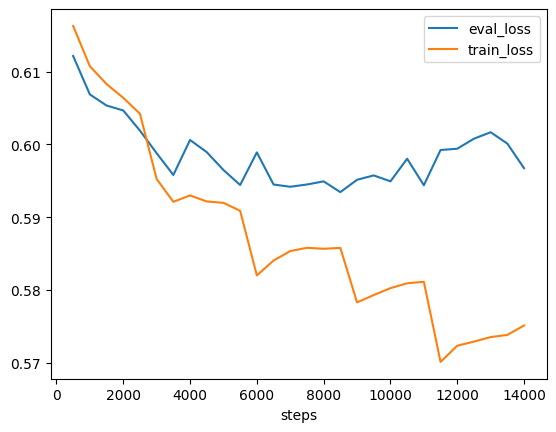

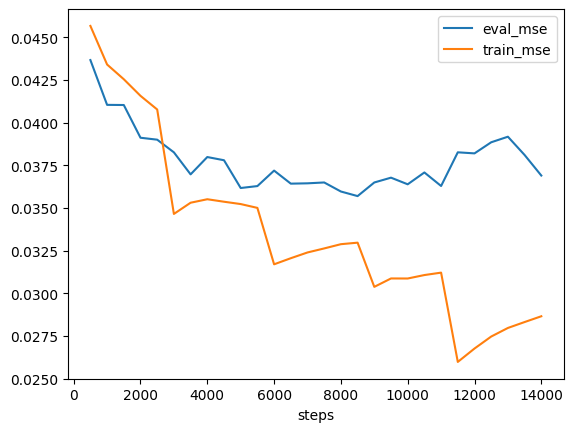

In [26]:
# fig, ax = plt.subplots(figsize=(20,10)) 
df_metrics[['eval_loss','train_loss']].plot() 
df_metrics[['eval_mse','train_mse']].plot() 
# df.plot(x = 'day', y = 'humidity', ax = ax, secondary_y = True) 